In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from datetime import datetime

In [2]:
def animate_density_evolution(dimensions: tuple[int, int], filename: str, interval: int = 100, repeat: bool = False) -> FuncAnimation:
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(np.zeros(dimensions).T, cmap='viridis', origin='lower', animated=True)
    plt.colorbar(img)
    
    ax.set_title('Density Evolution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    def init():
        img.set_array(np.zeros(dimensions).T)
        return [img]
    
    def update(frame):
        # Reshape the flattened data back to 2D and transpose
        current_density = df.iloc[frame].values.reshape(dimensions, order='F').T
        img.set_array(current_density)
        img.set_clim(vmin=df.values.min(), vmax=df.values.max())
        return [img]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(df),
                        init_func=init, blit=True,
                        interval=interval, repeat=repeat)
    
    return anim

In [3]:
def display_density_heatmap(density: NDArray[np.float64], title: str = 'Density Distribution'):
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(density.T, cmap='viridis', origin='lower')
    plt.colorbar(heatmap, label='Density')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

In [4]:
def visualize_velocity_field(velocity_field: NDArray[np.float64], title: str = 'Velocity Field') -> None:
    """
    Visualize a 2D velocity field using quiver plot.
    
    Args:
        velocity_field: Array of shape (2, height, width) containing x and y components of velocity
        title: Title of the plot
    """
    # Get dimensions of the field
    _, width, height = velocity_field.shape
    
    # Create coordinate meshgrid
    x, y = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    
    # Extract x and y components of velocity
    u = velocity_field[0]  # x-component
    v = velocity_field[1]  # y-component
    
    # Calculate velocity magnitude for color mapping
    magnitude = np.sqrt(u**2 + v**2)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot velocity vectors with magnitude-based coloring
    plt.quiver(x, y, u, v, magnitude, 
               cmap='viridis',
               scale=30,
               width=0.005)
    
    plt.colorbar(label='Velocity magnitude')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [5]:
def get_ring_initial_distribution(sites: tuple[int, int], 
                              cylinder_radius_outer: float,
                              cylinder_radius_inner: float,
                              background_density: float = 0.1,
                              ring_density: float = 0.4) -> NDArray[np.float64]:
    """
    Create a ring-shaped initial distribution.
    
    Args:
        sites: Tuple of (height, width) for the grid
        cylinder_radius_outer: Outer radius of the ring
        cylinder_radius_inner: Inner radius of the ring
        background_density: Density value outside the ring
        ring_density: Density value in the ring region
        
    Returns:
        density: Initial density distribution with a ring pattern
    """
    # Initialize density array with background value
    density = np.full(sites, background_density)
    
    # Create coordinate grid
    x = np.arange(sites[0])
    y = np.arange(sites[1])
    X, Y = np.meshgrid(x, y)
    
    # Calculate center points
    center_x = sites[0] / 2
    center_y = sites[1] / 2
    
    # Create ring mask
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    ring_mask = ((distance_from_center < cylinder_radius_outer) & 
                 (distance_from_center > cylinder_radius_inner)).T
    
    # Set ring density
    density[ring_mask] = ring_density
    
    return density

def get_shear_velocity_field(sites: tuple[int, int], u_magnitude: float = 0.2, v_magnitude: float = 0.1) -> NDArray[np.float64]:
    """
    Create a shear velocity field with opposite horizontal velocities in upper and lower halves.
    
    Args:
        sites: Tuple of (width, height) for the grid
        u_magnitude: Magnitude of horizontal velocity
        v_magnitude: Magnitude of vertical velocity
        
    Returns:
        velocity_field: Array of shape (2, height, width) containing the velocity components
    """
    
    # Initialize velocity components with proper orientation
    u = np.full(sites, u_magnitude)
    v = np.full(sites, v_magnitude)
    
    
    u[:, int(sites[1] / 2):] = -u_magnitude
    
    # Stack into velocity field (u=horizontal velocity, v=vertical velocity)
    velocity_field = np.stack([u, v])
    
    return velocity_field

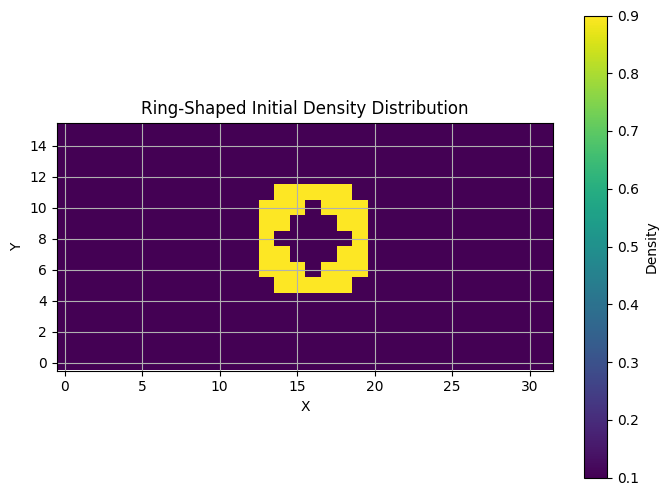

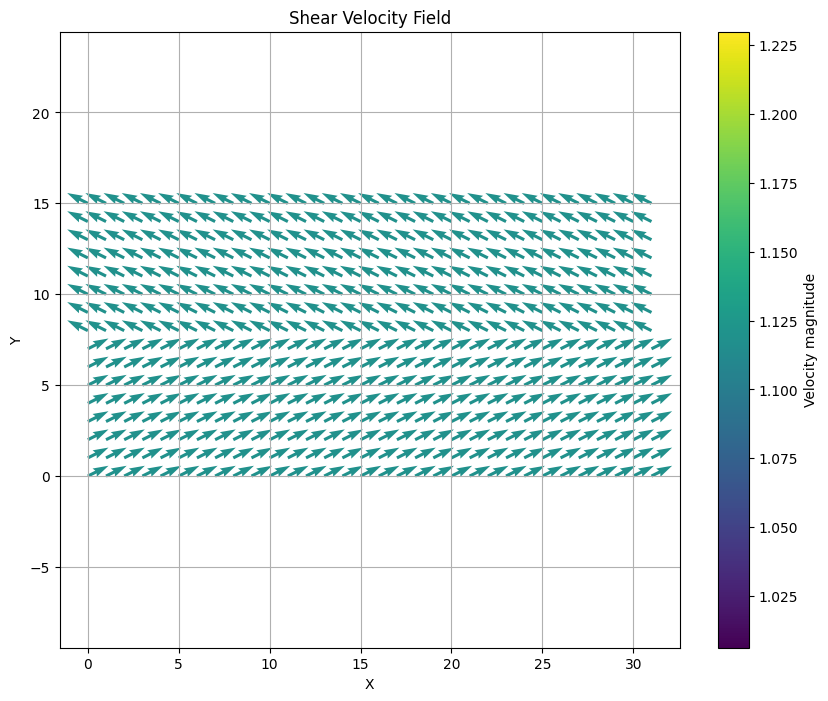

In [6]:
# Create new sites configuration
sites_ring = (32, 16)
links = [[0,0], [-1, 0], [1,0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]]
weights = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]
speed_of_sound = 1/np.sqrt(3)
# Define ring parameters
cylinder_radius_outer = 4
cylinder_radius_inner = 2
background_density = 0.1
ring_density = 0.9

# Create ring-shaped initial distribution
#
initial_dist_ring = get_ring_initial_distribution(sites_ring, cylinder_radius_outer, cylinder_radius_inner, background_density, ring_density)

# Visualize ring-shaped initial density
display_density_heatmap(initial_dist_ring, title='Ring-Shaped Initial Density Distribution')

# Create shear velocity field
shear_velocity_field = get_shear_velocity_field(sites_ring, u_magnitude=0.2, v_magnitude=0.1)

# Visualize shear velocity field
visualize_velocity_field(shear_velocity_field*5, title='Shear Velocity Field')

zero_velocity_field = np.stack([np.zeros(sites_ring), np.zeros(sites_ring)])
#visualize_velocity_field(zero_velocity_field, title='Zero Velocity Field')

# Update configuration for simulation
config_ring = [(50, shear_velocity_field, links, weights, speed_of_sound)]

In [7]:
import importlib
import qlbmlib
importlib.reload(qlbmlib)

<module 'qlbmlib' from 'd:\\Data\\Codes\\Quantum\\Research\\qlbmlib.py'>

In [8]:
# Create unique filename with timestamp for ring simulation
timestamp_ring = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_ring = f"experiments/generic/density_evolution_ring{timestamp_ring}.csv"

# Run simulation for ring configuration
density_ring = qlbmlib.simulate_flow(initial_dist_ring, config_ring, filename_ring, enable_quantum_macros=True)

print(f"Ring simulation complete. Results saved to {filename_ring}")

Circuit configuration: will run iterations 0-50/50 with this configuration
Iteration 1 running...
Iteration 1/50:
  Compilation: 2.636 seconds
  Execution: 1.564 seconds
  Total: 4.200 seconds
Iteration 2 running...
Iteration 2/50:
  Compilation: 2.471 seconds
  Execution: 1.948 seconds
  Total: 4.419 seconds
Iteration 3 running...
Iteration 3/50:
  Compilation: 3.729 seconds
  Execution: 2.007 seconds
  Total: 5.735 seconds
Iteration 4 running...
Iteration 4/50:
  Compilation: 4.031 seconds
  Execution: 1.420 seconds
  Total: 5.451 seconds
Iteration 5 running...
Iteration 5/50:
  Compilation: 2.479 seconds
  Execution: 1.131 seconds
  Total: 3.610 seconds
Iteration 6 running...
Iteration 6/50:
  Compilation: 2.444 seconds
  Execution: 1.187 seconds
  Total: 3.631 seconds
Iteration 7 running...
Iteration 7/50:
  Compilation: 3.722 seconds
  Execution: 2.553 seconds
  Total: 6.275 seconds
Iteration 8 running...
Iteration 8/50:
  Compilation: 3.753 seconds
  Execution: 0.824 seconds
  To

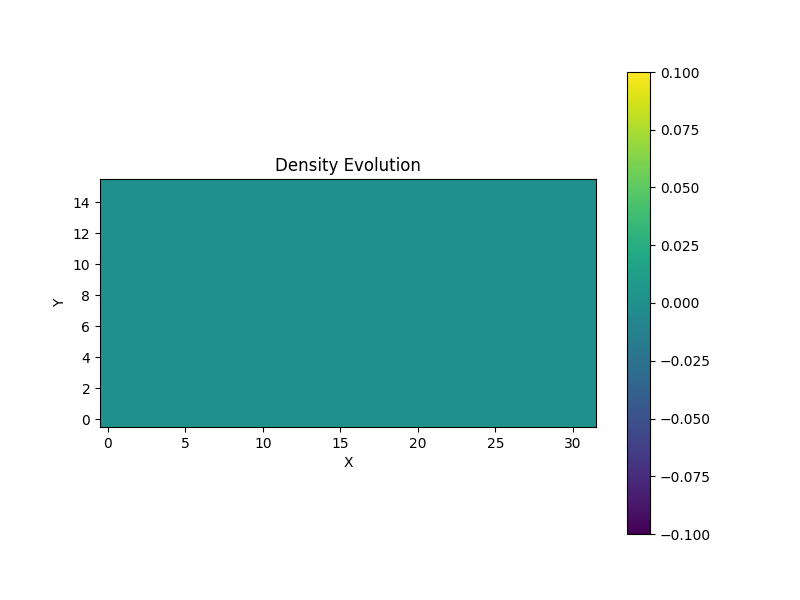

In [13]:
%matplotlib widget
anim = animate_density_evolution(sites_ring, filename_ring, interval=100, repeat=False)
plt.show()

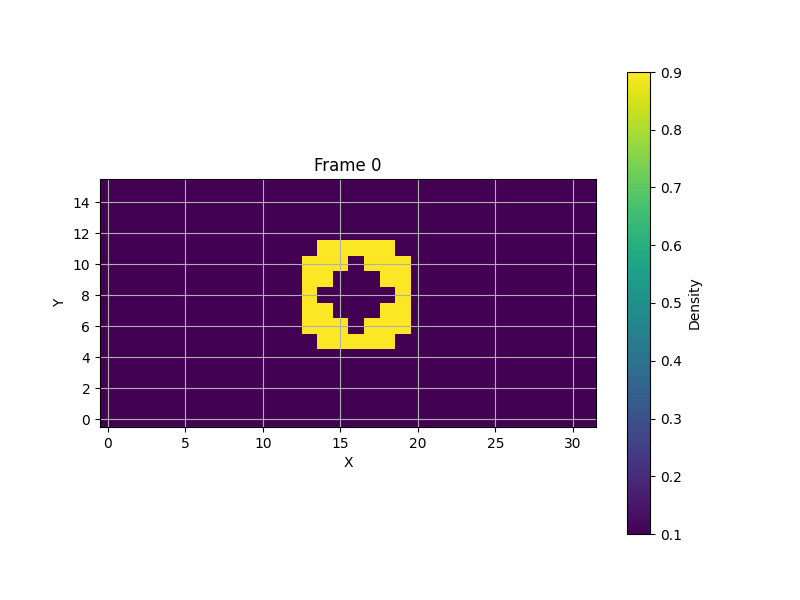

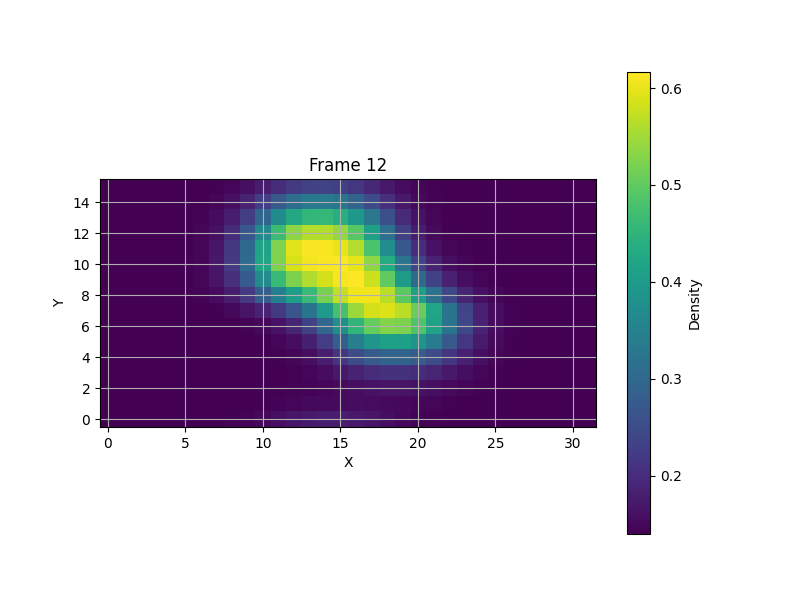

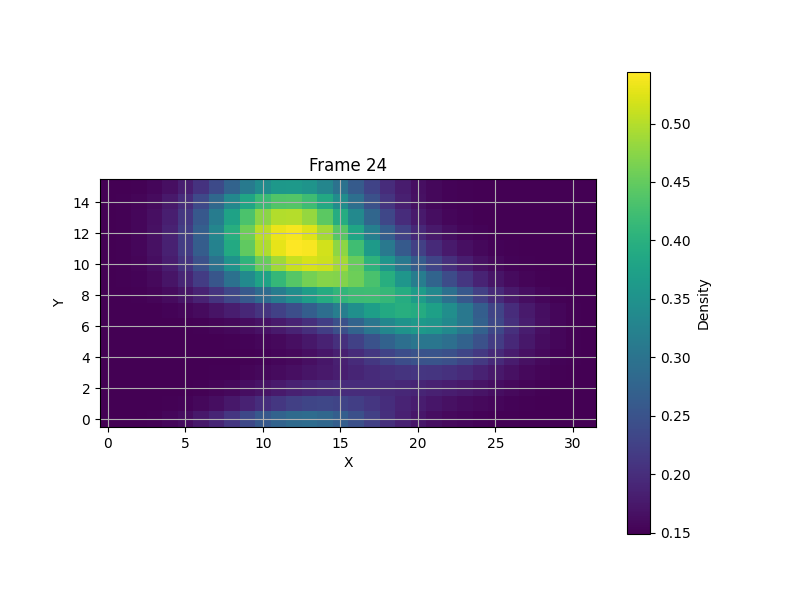

In [14]:
def display_frame(dimensions: tuple[int, int], filename: str, frame: int, title: str = None) -> None:
    """Display a specific frame from the simulation data file.
    
    Args:
        dimensions: Tuple of (height, width) for the grid
        filename: Path to the CSV file containing simulation data
        frame: Frame number to display (0-based index)
        title: Optional title for the plot
    """
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    if frame >= len(df):
        raise ValueError(f"Frame {frame} not found. File only has {len(df)} frames.")
    
    # Get the frame data and reshape it
    frame_data = df.iloc[frame].values.reshape(dimensions, order='F')
    
    # Create the heatmap
    display_density_heatmap(frame_data, title=title or f'Density Distribution at Frame {frame}')

# Example usage - display frame 5
frames_to_show = [0, 12, 24]  # Show initial, middle, and final frames
for frame in frames_to_show:
    display_frame(sites_ring, filename_ring, frame, f'Frame {frame}')
